In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
np.random.seed(2022)
torch.manual_seed(2022)

beta1 = np.array([-3.0, 1.0, 2.0, 0.0, -1.0])*5
beta2 = np.array([-2.0, -1.0, 4.0, 4.0, -2.0])*5
beta3 = np.array([-1.0, 2.0,  3.0, 2.0, -3.0])*5
beta4 = np.array([0.0, -2.0,  2.0, 3.0, 1.0])*5
beta5 = np.array([-5.0, 1.5,   1.0, -1.0, 2.0])*5
beta6 = np.array([2.0, -1.5,  2.0, -2.0, -3.0])*5
beta7 = np.array([-1.0, 0,     3.0, 3.0, -2.0])*5

sample_size = 10000
n = 7
nYear = 11

X = np.stack((np.ones(shape=sample_size),
              np.random.binomial(n=1, p=0.6, size=sample_size),   
              np.random.binomial(n=1, p=0.4, size=sample_size),   
              np.random.binomial(n=1, p=0.3, size=sample_size),
              np.random.binomial(n=1, p=0.7, size=sample_size)), 
              axis=1)


In [ ]:
theta = np.full((sample_size, n, nYear), 0.0)
a1 = 0.6
a2 = 0.8
Sigma1 = ((1-a1)*np.identity(n)+ a1*np.ones([n, n]))/10000000.0
Sigma2 = (1-a2)*np.identity(n)+ a2*np.ones([n, n])*2.0
#sig = np.array([0.4,0.35,0.5,0.45,0.33,0.4, 0.5])*1.8
epsilon = np.random.multivariate_normal([0]*n, Sigma1, size=nYear)

for i in range(sample_size):
    for t in range(nYear):
        if t==0:
            theta[i,:,t] = np.random.multivariate_normal([0]*n,Sigma2)
        else:
            theta[i,:,t] = theta[i,:,t-1] + epsilon[t, :]
            

In [ ]:
epsilon.shape

(11, 7)

In [ ]:
def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y

In [ ]:
p_star = np.full((sample_size, n, nYear), 0.0)
for i in range(sample_size):
  for t in range(nYear):
    p_star[i,:,t] = softmax(theta[i,:,t]*10)

In [ ]:
print(X.shape, theta.shape)   # [N,5], [N,T,7]

(10000, 5) (10000, 7, 11)


In [ ]:
p_star2 = np.full((sample_size, n), 0.0)

for i in range(sample_size):
    p_star2[i,:] = softmax(np.array([np.sum(X[i,:]*beta1), np.sum(X[i,:]*beta2), np.sum(X[i,:]*beta3), np.sum(X[i,:]*beta4), np.sum(X[i,:]*beta5), np.sum(X[i,:]*beta6), np.sum(X[i,:]*beta7)]))

In [ ]:
p_star2 = p_star2[:,:,np.newaxis]
p = (p_star*5 + p_star2)/6.0

In [ ]:
Y  = np.full((sample_size, nYear, n), 0.0)
for i in range(sample_size):
  for t in range(nYear):
    Y[i,t,:] = np.random.multinomial(n=1, pvals = p[i,:,t])

In [ ]:
Y.shape   # [N, T, 10]

(10000, 11, 7)

In [ ]:
Y_label = Y.argmax(axis=2)

In [ ]:
Y_label[0]

array([0, 3, 6, 6, 3, 2, 3, 6, 3, 6, 6])

In [ ]:
Y_label.shape

(10000, 11)

#1. Softmax with X only

In [ ]:
N_valid = int(sample_size*0.6)
x_train = X[:N_valid]
x_test = X[N_valid:]
y_train = Y_label[:N_valid,-1]
y_test = Y_label[N_valid:, -1]

In [ ]:
Y_label[:3]

array([[0, 3, 6, 6, 3, 2, 3, 6, 3, 6, 6],
       [3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2]])

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6000, 5) (6000,) (4000, 5) (4000,)


In [ ]:
x_train = torch.tensor(x_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
train_data = TensorDataset(x_train, y_train)
trainloader = DataLoader(dataset = train_data, batch_size=32, shuffle=True)

x_test = torch.tensor(x_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)
test_data = TensorDataset(x_test, y_test)
testloader= DataLoader(dataset = test_data, batch_size=32, shuffle=True)

In [ ]:
print(x_train.shape, y_train.shape)

torch.Size([6000, 5]) torch.Size([6000])


In [ ]:
input_size = x_train.shape[1]
input_size

5

In [ ]:
class softmaxclassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = input_size 
    self.linear = nn.Linear(input_size,7)

  def forward(self,x):
    x = self.linear(x)

    return x


In [ ]:
model_sf1 = softmaxclassifier()
optimizer = torch.optim.SGD(model_sf1.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
model_sf1

softmaxclassifier(
  (linear): Linear(in_features=5, out_features=7, bias=True)
)

In [ ]:
%%time 

loss_graph = []
epochs = 800
history=[]
model_sf1.train()

for epoch in range(epochs):
  running_loss = 0.0
  for xx, yy in trainloader:
    yhat = model_sf1(xx)
    loss = loss_ftn(yhat, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)

  loss_graph.append(running_loss/len(trainloader.dataset))
  if epoch % 100 == 0:
      print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(trainloader.dataset)))

[epoch: 0] loss: 2.0201
[epoch: 100] loss: 1.8989
[epoch: 200] loss: 1.8989
[epoch: 300] loss: 1.8989
[epoch: 400] loss: 1.8990
[epoch: 500] loss: 1.8989
[epoch: 600] loss: 1.8989
[epoch: 700] loss: 1.8989
CPU times: user 1min 34s, sys: 278 ms, total: 1min 35s
Wall time: 1min 36s


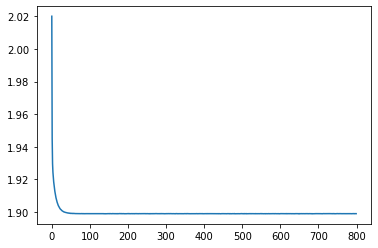

In [ ]:
plt.plot(loss_graph)

In [ ]:
def testAccuracy():
    
    model_sf1.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for xx, yy in testloader:
            outputs = model_sf1(xx)
            _, predicted = torch.max(outputs.data, 1)
            total += xx.shape[0]
            accuracy += (predicted == yy).sum().item()
    accuracy = (100 * accuracy / total)
    print('Test Accuracy of SoftmaxClassifier: %.2f%%' %(accuracy))

testAccuracy()

Test Accuracy of SoftmaxClassifier: 26.90%


In [ ]:
__, pred = torch.max(model_sf1(x_test).data, 1)
multiprecision = MulticlassPrecision(num_classes=7)
sf_x_prec = multiprecision(pred, y_test)

multirecall = MulticlassRecall(num_classes=7)
sf_x_recall = multirecall(pred, y_test)

print(sf_x_prec, sf_x_recall)

tensor(0.1082) tensor(0.1874)


#2. Softmax with X,Y1,...,Y10

In [ ]:
X_train = np.concatenate([X[:N_valid], Y_label[:N_valid, :-1]], axis=1)
X_test = np.concatenate([X[N_valid:], Y_label[N_valid:, :-1]], axis=1)
Y_train = Y_label[:N_valid, -1]
Y_test = Y_label[N_valid:, -1]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
X_train = torch.tensor(X_train, dtype = torch.float32)
Y_train = torch.tensor(Y_train, dtype = torch.int64)
train_data = TensorDataset(X_train, Y_train)
trainloader= DataLoader(dataset = train_data, batch_size=128, shuffle=True)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.int64)
test_data = TensorDataset(X_test, Y_test)
testloader= DataLoader(dataset = test_data, batch_size=128, shuffle=True)

In [ ]:
input_size = X_train.shape[1]
input_size

15

In [ ]:
class softmaxclassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = input_size 
    self.linear = nn.Linear(input_size,7)

  def forward(self,x):
    x = self.linear(x)

    return x


In [ ]:
model_sf2 = softmaxclassifier()
optimizer = torch.optim.SGD(model_sf2.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
print(model_sf2)

softmaxclassifier(
  (linear): Linear(in_features=15, out_features=7, bias=True)
)


In [ ]:
%%time

loss_graph = []
epochs = 800
history=[]
model_sf2.train()

for epoch in range(epochs):
  running_loss = 0.0
  for xx, yy in trainloader:
    yhat = model_sf2(xx)
    loss = loss_ftn(yhat, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)

  loss_graph.append(running_loss/len(trainloader.dataset))
  if epoch % 100 == 0:
      print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(trainloader.dataset)))

[epoch: 0] loss: 2.0362
[epoch: 100] loss: 1.5933
[epoch: 200] loss: 1.5710
[epoch: 300] loss: 1.5614
[epoch: 400] loss: 1.5563
[epoch: 500] loss: 1.5536
[epoch: 600] loss: 1.5528
[epoch: 700] loss: 1.5520
CPU times: user 49.3 s, sys: 135 ms, total: 49.4 s
Wall time: 49.9 s


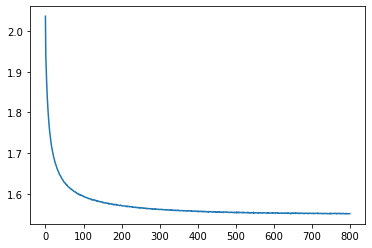

In [ ]:
plt.plot(loss_graph)

In [ ]:
def testAccuracy():
    
    model_sf2.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for xx, yy in testloader:
            outputs = model_sf2(xx)
            _, predicted = torch.max(outputs.data, 1)
            total += xx.shape[0]
            accuracy += (predicted == yy).sum().item()
    
    accuracy = (100 * accuracy / total)
    print('Test Accuracy of SoftmaxClassifier: %.2f%%' %(accuracy))

testAccuracy()

Test Accuracy of SoftmaxClassifier: 37.38%


In [ ]:
__, pred = torch.max(model_sf2(X_test).data, 1)
multiprecision = MulticlassPrecision(num_classes=7)
sf_xy_prec = multiprecision(pred, Y_test)
multirecall = MulticlassRecall(num_classes=7)
sf_xy_recall = multirecall(pred, Y_test)

print(sf_xy_prec, sf_xy_recall)

tensor(0.4461) tensor(0.3538)


#3. DNN with X only

In [ ]:
N_valid = int(sample_size*0.6)
x_train = X[:N_valid]
x_test = X[N_valid:]
y_train = Y_label[:N_valid,-1]
y_test = Y_label[N_valid:, -1]

from torch.utils.data import TensorDataset, DataLoader
x_train = torch.tensor(x_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
train_data = TensorDataset(x_train, y_train)
trainloader = DataLoader(dataset = train_data, batch_size=32, shuffle=True)

x_test = torch.tensor(x_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)
test_data = TensorDataset(x_test, y_test)
testloader= DataLoader(dataset = test_data, batch_size=32, shuffle=True)

In [ ]:
input_size = x_train.shape[1]
input_size

5

In [ ]:
class DNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = input_size 
    self.linear1 = torch.nn.Linear(input_size,15)
    self.linear2 = torch.nn.Linear(15,10)
    self.linear3 = torch.nn.Linear(10,7)
    self.m = torch.nn.ReLU()
    
  def forward(self, x):
    x = self.linear1(x)
    x = self.m(x)
    x = self.linear2(x)
    x = self.m(x)
    x = self.linear3(x)
    
    return x

In [ ]:
model_dnn1 = DNN()
optimizer = torch.optim.SGD(model_dnn1.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
print(model_dnn1)

DNN(
  (linear1): Linear(in_features=5, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=7, bias=True)
  (m): ReLU()
)


In [ ]:
%%time
loss_graph = []
epochs = 800
history=[]
model_dnn1.train()

for epoch in range(epochs):
  running_loss = 0.0
  for xx, yy in trainloader:
    yhat = model_dnn1(xx)
    loss = loss_ftn(yhat, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
  
  loss_graph.append(running_loss/len(trainloader.dataset))
  
  if epoch % 100 == 0:
      print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(trainloader.dataset)))

[epoch: 0] loss: 1.9398
[epoch: 100] loss: 1.8950
[epoch: 200] loss: 1.8888
[epoch: 300] loss: 1.8865
[epoch: 400] loss: 1.8855
[epoch: 500] loss: 1.8848
[epoch: 600] loss: 1.8842
[epoch: 700] loss: 1.8838
CPU times: user 2min 9s, sys: 339 ms, total: 2min 9s
Wall time: 2min 10s


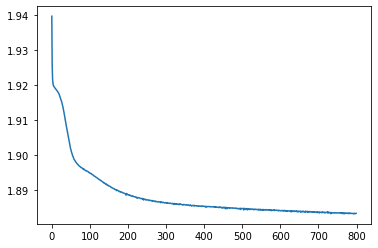

In [ ]:
plt.plot(loss_graph)

In [ ]:
def DNN_testAccuracy():
    
    model_dnn1.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for xx, yy in testloader:
            outputs = model_dnn1(xx)
            _, predicted = torch.max(outputs.data, 1)
            total += xx.shape[0]
            # print(total)
            accuracy += (predicted == yy).sum().item()
    
    accuracy = (100 * accuracy / total)
    print('Test Accuracy of DNN: %.2f%%' %(accuracy))

DNN_testAccuracy()

Test Accuracy of DNN: 27.30%


In [ ]:
__, pred = torch.max(model_dnn1(x_test).data, 1)

multiprecision = MulticlassPrecision(num_classes=7)
dnn_x_prec = multiprecision(pred, y_test)
multirecall = MulticlassRecall(num_classes=7)
dnn_x_recall = multirecall(pred, y_test)

print(dnn_x_prec, dnn_x_recall)

tensor(0.1528) tensor(0.2016)


#4. DNN with X,Y1,...,Y10

In [ ]:
X_train = np.concatenate([X[:N_valid], Y_label[:N_valid, :-1]], axis=1)
X_test = np.concatenate([X[N_valid:], Y_label[N_valid:, :-1]], axis=1)
Y_train = Y_label[:N_valid, -1]
Y_test = Y_label[N_valid:, -1]

from torch.utils.data import TensorDataset, DataLoader
X_train = torch.tensor(X_train, dtype = torch.float32)
Y_train = torch.tensor(Y_train, dtype = torch.int64)
train_data = TensorDataset(X_train, Y_train)
trainloader= DataLoader(dataset = train_data, batch_size=128, shuffle=True)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.int64)
test_data = TensorDataset(X_test, Y_test)
testloader= DataLoader(dataset = test_data, batch_size=128, shuffle=True)

In [ ]:
input_size = X_train.shape[1]

In [ ]:
class DNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = input_size 
    self.linear1 = torch.nn.Linear(input_size,15)
    self.linear2 = torch.nn.Linear(15,10)
    self.linear3 = torch.nn.Linear(10,7)
    self.m = torch.nn.ReLU()
    
  def forward(self, x):
    x = self.linear1(x)
    x = self.m(x)
    x = self.linear2(x)
    x = self.m(x)
    x = self.linear3(x)
    
    return x

In [ ]:
model_dnn2 = DNN()
optimizer = torch.optim.SGD(model_dnn2.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
%%time
loss_graph = []
epochs = 800
history=[]
model_dnn2.train()

for epoch in range(epochs):
  running_loss = 0.0
  for xx, yy in trainloader:
    yhat = model_dnn2(xx)
    loss = loss_ftn(yhat, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
  
  history.append(loss.item())
  loss_graph.append(running_loss/len(trainloader.dataset))
  if epoch % 100 == 0:
      print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(trainloader.dataset)))

[epoch: 0] loss: 1.9938
[epoch: 100] loss: 1.5058
[epoch: 200] loss: 1.4037
[epoch: 300] loss: 1.3504
[epoch: 400] loss: 1.2902
[epoch: 500] loss: 1.2511
[epoch: 600] loss: 1.2149
[epoch: 700] loss: 1.1963
CPU times: user 57.2 s, sys: 147 ms, total: 57.3 s
Wall time: 57.4 s


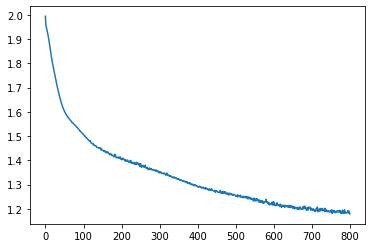

In [ ]:
plt.plot(loss_graph)

In [ ]:
def DNN_testAccuracy():
    
    model_dnn2.eval()
    accuracy = 0.0
    total = 0.0  
    
    with torch.no_grad():
        for xx, yy in testloader:
            outputs = model_dnn2(xx)
            _, predicted = torch.max(outputs.data, 1)
            total += xx.shape[0]
            accuracy += (predicted == yy).sum().item()
    
    accuracy = (100 * accuracy / total)
    print(predicted)
    print(yy)
    print('Test Accuracy of DNN: %.2f%%' %(accuracy))

DNN_testAccuracy()

tensor([5, 1, 0, 0, 4, 3, 0, 3, 5, 5, 1, 3, 1, 4, 2, 4, 1, 3, 3, 2, 2, 4, 5, 4,
        4, 0, 5, 3, 3, 1, 4, 3])
tensor([5, 1, 0, 3, 4, 3, 0, 3, 4, 6, 2, 3, 1, 4, 3, 4, 1, 1, 3, 2, 3, 4, 5, 4,
        5, 3, 3, 4, 2, 1, 3, 3])
Test Accuracy of DNN: 58.80%


In [ ]:
__, pred = torch.max(model_dnn2(X_test).data, 1)

multiprecision = MulticlassPrecision(num_classes=7)
dnn_xy_prec = multiprecision(pred, Y_test)
multirecall = MulticlassRecall(num_classes=7)
dnn_xy_recall = multirecall(pred, Y_test)

print(dnn_xy_prec, dnn_xy_recall)


tensor(0.5931) tensor(0.6181)


#5. RNN with X only

In [ ]:
XX_train = np.stack([X[:N_valid]]*10, axis=1)
Train_label = Y_label[:N_valid, 1:, np.newaxis]
print(XX_train.shape)
print(Train_label.shape)

XX_test = np.stack([X[N_valid:]]*10, axis=1)
Test_label = Y_label[N_valid:, 1:, np.newaxis]

print(XX_test.shape)
print(Test_label.shape)

XX_train = torch.tensor(XX_train, dtype=torch.float32)
Train_label = torch.tensor(Train_label, dtype=torch.int64)
Train_data = TensorDataset(XX_train, Train_label)
Trainloader= DataLoader(dataset = Train_data, batch_size = 32, shuffle=True)

XX_test = torch.tensor(XX_test, dtype=torch.float32)
Test_label = torch.tensor(Test_label, dtype=torch.int64)
Test_data = TensorDataset(XX_test, Test_label)
Testloader= DataLoader(dataset = Test_data, batch_size = 32, shuffle=True)

(6000, 10, 5)
(6000, 10, 1)
(4000, 10, 5)
(4000, 10, 1)


In [ ]:
input_size = XX_train.shape[2]  #5
num_layers = 3
hidden_size = 6

In [ ]:
class many_to_many_rnn(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(many_to_many_rnn, self).__init__()
        self.hidden_size = hidden_size #8
        self.num_layers = num_layers #3
        self.input_size = input_size #5
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 7)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, hn = self.rnn(x, h0) 
        out = self.fc(out) 
        return out

In [ ]:
model_rnn1 = many_to_many_rnn(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
print(model_rnn1)

many_to_many_rnn(
  (rnn): RNN(5, 6, num_layers=3, batch_first=True)
  (fc): Linear(in_features=6, out_features=7, bias=True)
)


In [ ]:
optimizer = torch.optim.SGD(model_rnn1.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
%%time
loss_graph = []
num_epochs = 400
model_rnn1.train()
history=[]
for epoch in range(num_epochs):
    running_loss = 0.0  
    for xx, yy in Trainloader:
        out = model_rnn1(xx)
        loss = 0
        for t in range(10):
          loss = loss_ftn(out[:,t,:], yy[:,t,0])
          running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_graph.append(running_loss/len(Trainloader.dataset))

    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(Trainloader.dataset)))


[epoch: 0] loss: 0.6113
[epoch: 100] loss: 0.5952
[epoch: 200] loss: 0.5939
[epoch: 300] loss: 0.5937
CPU times: user 3min 6s, sys: 284 ms, total: 3min 7s
Wall time: 3min 7s


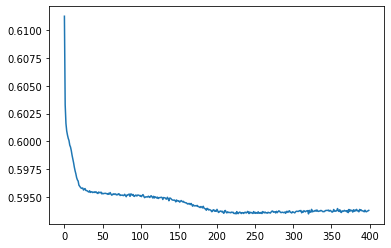

In [ ]:
plt.plot(loss_graph)

In [ ]:
def RNN_testAccuracy():
    
    model_rnn1.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for xx, yy in Testloader:
            outputs = model_rnn1(xx)
            _, predicted = torch.max(outputs.data, 2)
            predicted = predicted[:,:,np.newaxis]
            total += xx.shape[0]*10
            accuracy += (predicted == yy).sum().item()

    accuracy = (100 * accuracy / total)
    print('Test Accuracy of RNN: %.2f%%' %(accuracy))
    
RNN_testAccuracy()

Test Accuracy of RNN: 25.43%


In [ ]:
__, pred = torch.max(model_rnn1(XX_test).data, 2)
pred = pred.reshape(-1,1)
Y = Test_label.reshape(-1,1)

multiprecision = MulticlassPrecision(num_classes=7)
rnn_x_prec = multiprecision(pred, Y)
multirecall = MulticlassRecall(num_classes=7)
rnn_x_recall = multirecall(pred, Y)

print(rnn_x_prec, rnn_x_recall)


tensor(0.1479) tensor(0.1861)


#6. RNN with X, Y1,...,Y10

In [ ]:
XX_train = np.stack([X[:N_valid]]*10, axis=1)
print(XX_train.shape)
YY_label_train =  Y_label[:N_valid, :-1, np.newaxis]
print(YY_label_train.shape)

Train = np.concatenate([XX_train, YY_label_train], axis=2)
Train_label = Y_label[:N_valid, 1:, np.newaxis]

print(Train.shape)
print(Train_label.shape)

(6000, 10, 5)
(6000, 10, 1)
(6000, 10, 6)
(6000, 10, 1)


In [ ]:
XX_test = np.stack([X[N_valid:]]*10, axis=1)
print(XX_test.shape)
YY_label_test =  Y_label[N_valid:, :-1, np.newaxis]
print(YY_label_test.shape)

Test = np.concatenate([XX_test, YY_label_test], axis=2)
Test_label = Y_label[N_valid:, 1:, np.newaxis]
print(Test.shape)
print(Test_label.shape)

(4000, 10, 5)
(4000, 10, 1)
(4000, 10, 6)
(4000, 10, 1)


In [ ]:
Train = torch.tensor(Train, dtype=torch.float32)
Train_label = torch.tensor(Train_label, dtype=torch.int64)
Train_data = TensorDataset(Train, Train_label)
Trainloader= DataLoader(dataset = Train_data, batch_size = 32, shuffle=True)

Test = torch.tensor(Test, dtype=torch.float32)
Test_label = torch.tensor(Test_label, dtype=torch.int64)
Test_data = TensorDataset(Test, Test_label)
Testloader= DataLoader(dataset = Test_data, batch_size = 32, shuffle=True)

In [ ]:
input_size = Train.shape[2]  # 6
num_layers = 3
hidden_size = 6

In [ ]:
class many_to_many_rnn(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(many_to_many_rnn, self).__init__()
        self.hidden_size = hidden_size #8
        self.num_layers = num_layers #3
        self.input_size = input_size #6
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 7)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, hn = self.rnn(x, h0) 
        out = self.fc(out) 
        return out

In [ ]:
model_rnn2 = many_to_many_rnn(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
model_rnn2

many_to_many_rnn(
  (rnn): RNN(6, 6, num_layers=3, batch_first=True)
  (fc): Linear(in_features=6, out_features=7, bias=True)
)

In [ ]:
optimizer = torch.optim.SGD(model_rnn2.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
%%time
loss_graph = []
num_epochs = 300
model_rnn2.train()
history=[]
for epoch in range(num_epochs):
    running_loss = 0.0  
    for xx, yy in Trainloader:
        out = model_rnn2(xx)
        loss = 0
        for t in range(10):
          loss = loss_ftn(out[:,t,:], yy[:,t,0])
          running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_graph.append(running_loss/len(Trainloader.dataset))
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(Trainloader.dataset)))

[epoch: 0] loss: 0.6098
[epoch: 100] loss: 0.4326
[epoch: 200] loss: 0.4171
CPU times: user 2min 20s, sys: 230 ms, total: 2min 20s
Wall time: 2min 20s


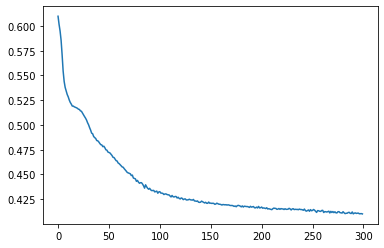

In [ ]:
plt.plot(loss_graph)

In [ ]:
def RNN_testAccuracy():
    
    model_rnn2.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for xx, yy in Testloader:
            outputs = model_rnn2(xx)
            _, predicted = torch.max(outputs.data, 2)
            predicted = predicted[:,:,np.newaxis]
            total += xx.shape[0]*10
            accuracy += (predicted == yy).sum().item()

    accuracy = (100 * accuracy / total)
    print('Test Accuracy of RNN: %.2f%%' %(accuracy))

RNN_testAccuracy()

Test Accuracy of RNN: 55.91%


In [ ]:
__, pred = torch.max(model_rnn2(Test).data, 2)
pred = pred.reshape(-1,1)
Y = Test_label.reshape(-1,1)

multiprecision = MulticlassPrecision(num_classes=7)
rnn_xy_prec = multiprecision(pred, Y)
multirecall = MulticlassRecall(num_classes=7)
rnn_xy_recall = multirecall(pred, Y)

print(rnn_xy_prec, rnn_xy_recall)


tensor(0.5727) tensor(0.5760)


-----

In [ ]:
XX_train = np.stack([X[:N_valid]]*10, axis=1)
Train_label = Y_label[:N_valid, 1:, np.newaxis]
print(XX_train.shape)
print(Train_label.shape)

XX_test = np.stack([X[N_valid:]]*10, axis=1)
Test_label = Y_label[N_valid:, 1:, np.newaxis]

print(XX_test.shape)
print(Test_label.shape)

XX_train = torch.tensor(XX_train, dtype=torch.float32)
Train_label = torch.tensor(Train_label, dtype=torch.int64)
Train_data = TensorDataset(XX_train, Train_label)
Trainloader= DataLoader(dataset = Train_data, batch_size = 32, shuffle=True)

XX_test = torch.tensor(XX_test, dtype=torch.float32)
Test_label = torch.tensor(Test_label, dtype=torch.int64)
Test_data = TensorDataset(XX_test, Test_label)
Testloader= DataLoader(dataset = Test_data, batch_size = 32, shuffle=True)

(6000, 10, 5)
(6000, 10, 1)
(4000, 10, 5)
(4000, 10, 1)


In [ ]:
input_size = XX_train.shape[2]  #5
num_layers = 3
hidden_size = 6

In [ ]:
class many_to_many_rnn(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(many_to_many_rnn, self).__init__()
        self.hidden_size = hidden_size #8
        self.num_layers = num_layers #3
        self.input_size = input_size #5
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 7)   # fully connected
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, hn = self.rnn(x, h0) 
        out = self.fc(out[:,-1,:]) 
        return out

In [ ]:
model_rnn1 = many_to_many_rnn(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
print(model_rnn1)

many_to_many_rnn(
  (rnn): RNN(5, 6, num_layers=3, batch_first=True)
  (fc): Linear(in_features=6, out_features=7, bias=True)
)


In [ ]:
optimizer = torch.optim.SGD(model_rnn1.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
%%time
loss_graph = []
num_epochs = 800
model_rnn1.train()
history=[]
for epoch in range(num_epochs):
    running_loss = 0.0  
    for xx, yy in Trainloader:
        out = model_rnn1(xx)
        yy = yy[:,-1,:].squeeze(dim=-1)
        loss = loss_ftn(out, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(xx)

    loss_graph.append(running_loss/len(Trainloader.dataset))
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(Trainloader.dataset)))


[epoch: 0] loss: 1.9560
[epoch: 100] loss: 1.8931
[epoch: 200] loss: 1.8895
[epoch: 300] loss: 1.8883
[epoch: 400] loss: 1.8876
[epoch: 500] loss: 1.8869
[epoch: 600] loss: 1.8866
[epoch: 700] loss: 1.8858
CPU times: user 9min 12s, sys: 940 ms, total: 9min 13s
Wall time: 9min 13s


In [ ]:
out.shape

torch.Size([16, 7])

In [ ]:
yy.shape

torch.Size([16])

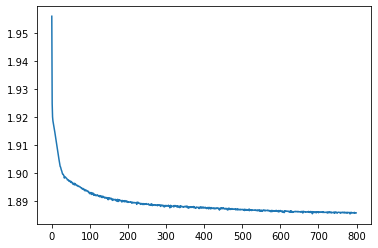

In [ ]:
plt.plot(loss_graph)

In [ ]:
def RNN_testAccuracy():
    
    model_rnn1.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for xx, yy in Testloader:
            outputs = model_rnn1(xx)
            _, predicted = torch.max(outputs.data, 1)
            yy = yy[:,-1,:].squeeze(dim=-1)
            total += xx.shape[0]
            accuracy += (predicted == yy).sum().item()
    accuracy = (100*accuracy / total)
    print(predicted)
    print(yy)
    print('Test Accuracy of RNN: %.2f%%' %(accuracy))
    
RNN_testAccuracy()

tensor([2, 3, 3, 3, 2, 3, 3, 5, 3, 2, 3, 3, 2, 2, 2, 3, 5, 3, 3, 2, 3, 5, 2, 3,
        3, 2, 3, 3, 2, 3, 2, 3])
tensor([2, 6, 1, 2, 3, 3, 0, 5, 3, 4, 0, 1, 5, 2, 0, 6, 1, 0, 1, 0, 3, 2, 3, 4,
        6, 1, 3, 5, 6, 5, 1, 4])
Test Accuracy of RNN: 26.95%


In [ ]:
__, pred = torch.max(model_rnn1(XX_test).data, 1)
Y = Test_label[:,-1,:].squeeze(dim=-1)

multiprecision = MulticlassPrecision(num_classes=7)
rnn_x_prec = multiprecision(pred, Y)
multirecall = MulticlassRecall(num_classes=7)
rnn_x_recall = multirecall(pred, Y)

print(rnn_x_prec, rnn_x_recall)


tensor(0.1082) tensor(0.1974)


In [ ]:
(pred==Y).sum()

tensor(1092)

In [ ]:
XX_train = np.stack([X[:N_valid]]*10, axis=1)
print(XX_train.shape)
YY_label_train =  Y_label[:N_valid, :-1, np.newaxis]
print(YY_label_train.shape)

Train = np.concatenate([XX_train, YY_label_train], axis=2)
Train_label = Y_label[:N_valid, 1:, np.newaxis]

print(Train.shape)
print(Train_label.shape)

(6000, 10, 5)
(6000, 10, 1)
(6000, 10, 6)
(6000, 10, 1)


In [ ]:
XX_test = np.stack([X[N_valid:]]*10, axis=1)
print(XX_test.shape)
YY_label_test =  Y_label[N_valid:, :-1, np.newaxis]
print(YY_label_test.shape)

Test = np.concatenate([XX_test, YY_label_test], axis=2)
Test_label = Y_label[N_valid:, 1:, np.newaxis]
print(Test.shape)
print(Test_label.shape)

(4000, 10, 5)
(4000, 10, 1)
(4000, 10, 6)
(4000, 10, 1)


In [ ]:
Train = torch.tensor(Train, dtype=torch.float32)
Train_label = torch.tensor(Train_label, dtype=torch.int64)
Train_data = TensorDataset(Train, Train_label)
Trainloader= DataLoader(dataset = Train_data, batch_size = 32, shuffle=True)

Test = torch.tensor(Test, dtype=torch.float32)
Test_label = torch.tensor(Test_label, dtype=torch.int64)
Test_data = TensorDataset(Test, Test_label)
Testloader= DataLoader(dataset = Test_data, batch_size = 32, shuffle=True)

In [ ]:
input_size = Train.shape[2]  # 6
num_layers = 3
hidden_size = 6

In [ ]:
class many_to_many_rnn(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(many_to_many_rnn, self).__init__()
        self.hidden_size = hidden_size #8
        self.num_layers = num_layers #3
        self.input_size = input_size #6
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 7)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, hn = self.rnn(x, h0) 
        out = self.fc(out[:,-1,:]) 
        return out

In [ ]:
model_rnn2 = many_to_many_rnn(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
model_rnn2

many_to_many_rnn(
  (rnn): RNN(6, 6, num_layers=3, batch_first=True)
  (fc): Linear(in_features=6, out_features=7, bias=True)
)

In [ ]:
optimizer = torch.optim.SGD(model_rnn2.parameters(), lr = 0.01)
loss_ftn = torch.nn.CrossEntropyLoss()

In [ ]:
%%time
loss_graph = []
num_epochs = 800
model_rnn2.train()
history=[]
for epoch in range(num_epochs):
    running_loss = 0.0  
    for xx, yy in Trainloader:
        out = model_rnn2(xx)
        yy = yy[:,-1,:].squeeze(dim=-1)
        loss = loss_ftn(out, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(xx)

    loss_graph.append(running_loss/len(Trainloader.dataset))

    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/len(Trainloader.dataset)))

[epoch: 0] loss: 1.9097
[epoch: 100] loss: 1.1669
[epoch: 200] loss: 1.1072
[epoch: 300] loss: 1.0785
[epoch: 400] loss: 1.0701
[epoch: 500] loss: 1.0649
[epoch: 600] loss: 1.0563
[epoch: 700] loss: 1.0611
CPU times: user 9min 31s, sys: 948 ms, total: 9min 32s
Wall time: 9min 31s


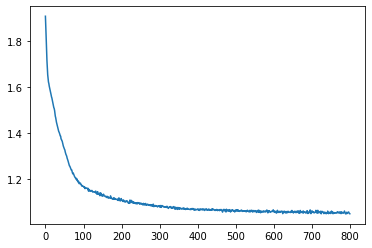

In [ ]:
plt.plot(loss_graph)

In [ ]:
def RNN_testAccuracy():
    
    model_rnn2.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for xx, yy in Testloader:
            outputs = model_rnn2(xx)
            _, predicted = torch.max(outputs.data, 1)
            # predicted = predicted[:,:,np.newaxis]
            yy = yy[:,-1,:].squeeze(dim=-1)
            total += xx.shape[0]
            accuracy += (predicted == yy).sum().item()

    accuracy = (100 * accuracy / total)
    print(predicted)
    print(yy)
    print('Test Accuracy of RNN: %.2f%%' %(accuracy))

RNN_testAccuracy()

tensor([1, 4, 3, 6, 2, 4, 2, 0, 2, 5, 6, 4, 0, 5, 4, 5, 2, 1, 6, 0, 5, 5, 5, 2,
        3, 3, 3, 2, 0, 5, 2, 6])
tensor([1, 4, 4, 6, 1, 4, 2, 6, 2, 2, 6, 4, 0, 5, 4, 2, 2, 1, 1, 1, 5, 5, 5, 5,
        4, 3, 3, 2, 3, 5, 3, 6])
Test Accuracy of RNN: 62.00%


In [ ]:
__, pred = torch.max(model_rnn2(Test).data, 1)
Y = Test_label[:,-1,:].squeeze(dim=-1)
multiprecision = MulticlassPrecision(num_classes=7)
rnn_xy_prec = multiprecision(pred, Y)
multirecall = MulticlassRecall(num_classes=7)
rnn_xy_recall = multirecall(pred, Y)

print(rnn_xy_prec, rnn_xy_recall)


tensor(0.6210) tensor(0.6539)
